In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import networkx as nx
import networkit as nk
import random

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_graphs(path):
    items = os.listdir(path)
    return [nx.read_edgelist(os.path.join(path, f), delimiter = "\t") for f in os.listdir(path)]

In [3]:
pred_dir = "/Users/alexdavies/Documents/Year_1/Project/GRAN_social/exp/GRAN/FACEBOOK/pred_graphs"
sample_dir = "/Users/alexdavies/Documents/Year_1/Project/GRAN_social/exp/GRAN/FACEBOOK/sample_graphs"
rmat_dir = "/Users/alexdavies/Documents/Year_1/Project/GRAN_social/exp/GRAN/FACEBOOK/rmat_graphs"


pred_graphs = get_graphs(pred_dir)
  # display the largest connected component for better visualization
vis_graphs = []
for gg in pred_graphs:
    CGs = [gg.subgraph(c) for c in nx.connected_components(gg)]
    CGs = sorted(CGs, key=lambda x: x.number_of_nodes(), reverse=True)
    vis_graphs += [CGs[0]]
    
pred_graphs = vis_graphs
sample_graphs = get_graphs(sample_dir)

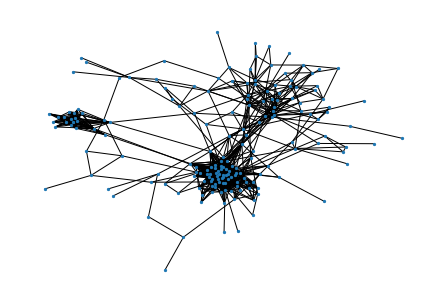

In [4]:
nx.draw(pred_graphs[8], node_size = 5)

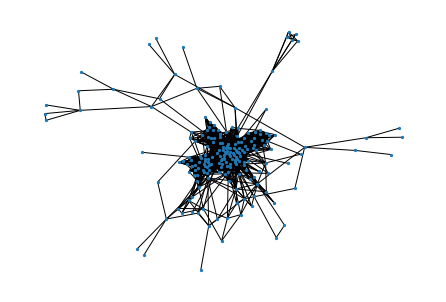

In [5]:
nx.draw(sample_graphs[8], node_size = 5)

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 



def SIR_full(G,T = 400, HM = 0.002, Gamma = 50, Nb_inf_init = 10,
             is_endpoint = False, is_inf_count = False):
    """ function that runs a simulation of an SIR model on a network.
    Args:
        Gamma(float): recovery rate
        Beta(float): infection probability
        Rho(float): initial fraction of infected individuals
        T(int): number of time steps simulated
    """

    N = len(list(G.nodes()))

    s =   [N - Nb_inf_init] #np.zeros(T)
    inf = [Nb_inf_init] #np.zeros(T)
    r =   [0] #np.zeros(T)

    """Make a graph with some infected nodes."""
    for u in G.nodes():
        G.nodes[u]["state"] = [0]
        G.nodes[u]["TimeInfected"] = 0
        G.nodes[u]["noeux_associes"] = [n for n in G.neighbors(u)]

    init = random.sample(list(G.nodes()), Nb_inf_init)
    for u in init:
        G.nodes[u]["state"][0] = 1
        G.nodes[u]["TimeInfected"] = 1
    
    # running simulation
    is_ended = False
    t = 1
    
    inf_count = 0
    while not is_ended:

        s.append(s[t-1])
        inf.append(inf[t-1])
        r.append(r[t-1])


        for u in G.nodes:
            
            current_state = G.nodes[u]["state"][t-1]
            
            if current_state == 0:
                G.nodes[u]["state"] += [0]
            elif current_state == 2:
                G.nodes[u]["state"] += [2]
            else:
                time_infected = len(np.argwhere(G.nodes[u]["state"]))
                
                if time_infected < Gamma:
                    G.nodes[u]["state"] += [1]
                else:
                    G.nodes[u]["state"] += [2]
                    
                    r[t] += 1
                    inf[t] += -1

        # check contagion
        for u in G.nodes:
            #if susceptible
            if G.nodes[u]["state"][t] == 0:
                
                for n in G.nodes[u]["noeux_associes"]:
                    if G.nodes[n]["state"][t] == 1: # if friend is infected
                        
                        if np.random.rand() < HM:
                            # print("this one is infected")
                            # print(G.nodes[u]["state"][t])
                            G.nodes[u]["state"][t] = 1
                            # print(G.nodes[u]["state"][t])
                            # print("\n")
                            inf[t] += 1
                            s[t] += -1
                            
                            inf_count += 1
                            
                            break

        if inf[t] == 0 or t == T: #
            is_ended = True
        t += 1
    
    if is_endpoint:
        node_example = G.nodes[list(G.nodes())[0]]
        return len(node_example["state"])
    elif is_inf_count:
        return inf_count
    
    return G


def simple_update(num, layout, G, ax):
    ax.clear()

    # Draw the graph with random node colors
    # print(num)
    
    # for node in list(G.nodes()):
    #     print(len(G.nodes[node]["state"]))
    
    step_states = [G.nodes[node]["state"][num] for node in list(G.nodes())]
    
    colormap = {0:"blue", 1:"red", 2:"green"}
    
    colors = []
    for s in step_states:
        colors.append(colormap[s])
    
    # print(random_colors)
    # random_colors = np.random.randint(2, size=n)
    nx.draw(G, pos=layout, node_color=colors, ax=ax, node_size = 5)

    # Set the title
    ax.set_title("Frame {}".format(num))
    
# def sir_update(G)


def simple_animation(G):

    # Build plot
    fig, ax = plt.subplots(figsize=(6,4))

#     # Create a graph and layout
#     n = 30 # Number of nodes
#     m = 70 # Number of edges
#     G = nx.gnm_random_graph(n, m)
    # nsteps = len()
    layout = nx.spring_layout(G)
    layout = nx.nx_pydot.graphviz_layout(G, prog="sfdp")
    G = SIR_full(G)

    # n_steps = len(out_graph.nodes["0"]["state"])
    # print(n_steps)
    # print(np.arange(n_steps-1).shape)
    
    for node in list(G.nodes()):
        n_steps = len(G.nodes[node]["state"])
    
    
    # writergif = animation.FFMpegWriter(fps=30) 
    # anim.save(f, writer=writergif)
    
    ani = animation.FuncAnimation(fig, simple_update, frames=np.arange(n_steps), fargs=(layout, G, ax))
    ani.save('animation_1.gif', dpi = 300)
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


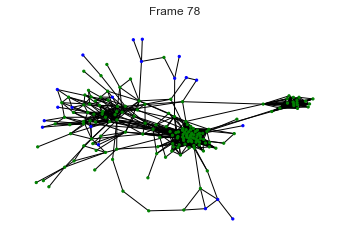

In [12]:
simple_animation(pred_graphs[8])

In [7]:
def find_spokes(G):
    nodes = G.degree()
    
    degree_sorted = sorted(nodes, key=lambda x: x[1])
    
    spokes = [x[0] for x in degree_sorted if x[1] == 1]
    
    n_spokes = len(spokes)
    
    return n_spokes

def all_degrees(G_list):
    degs = []
    for G in G_list:
        degs += [x[1] for x in G.degree()]
    return degs

In [8]:
sample_spokes = [find_spokes(G) for G in sample_graphs]
pred_spokes   = [find_spokes(G) for G in   pred_graphs]

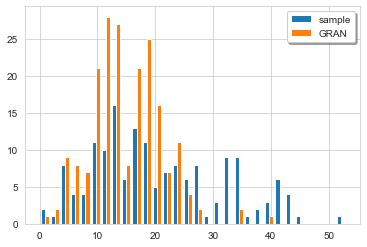

In [9]:
plt.hist([sample_spokes, pred_spokes], label=["sample", "GRAN"], bins = 30)
plt.legend(shadow = True)
plt.show()

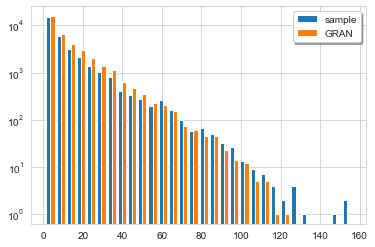

In [10]:
sample_degs = all_degrees(sample_graphs)
pred_degs   = all_degrees(pred_graphs)

plt.hist([sample_degs, pred_degs], label=["sample", "GRAN"], bins = 30)
plt.legend(shadow = True)
plt.yscale("log")
plt.show()

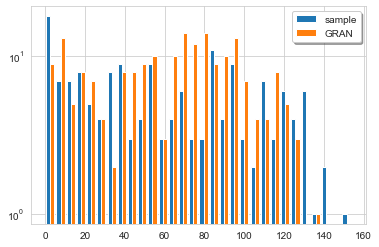

In [19]:
sample_endpoints = [SIR_full(G, is_inf_count = True) for G in sample_graphs]
pred_endpoints   = [SIR_full(G, is_inf_count = True) for G in pred_graphs]

plt.hist([sample_endpoints, pred_endpoints], label=["sample", "GRAN"], bins = 30)
plt.legend(shadow = True)
plt.yscale("log")
plt.show()

In [33]:


def get_paths(G):
    paths = nx.shortest_path_length(pred_graphs[2])
    all_paths = []
    for p in paths:
        for ip in p[1]:
            all_paths.append(p[1][ip])
    all_paths = np.array(all_paths)
    
    return all_paths
get_paths(pred_graphs[12])

array([0, 1, 1, ..., 9, 9, 9])